## Exploratory Data Analysis for Relative Permeability Sensitivity analysis results

In [1]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tkinter import Tk
from tkinter import filedialog

_ = Tk().withdraw()

In [2]:
# filename = filedialog.askopenfilename()
sandbox_directory = "D:\Geoslicer\sandbox"
slicerltrace_directory = "D:\Geoslicer\slicerltrace"

simulation_table = sandbox_directory + "\krel sensibility test bentheimer 400 6.csv"
experimental_table = sandbox_directory + "\krel_table_1.csv"
krel_result_py_path = (
    slicerltrace_directory + "\src\modules\PoreNetworkSimulationCLI\PoreNetworkSimulationCLILib\pnflow\krel_result.py"
)
cycle_table = sandbox_directory + "\krel_table_cycle2_1.csv"

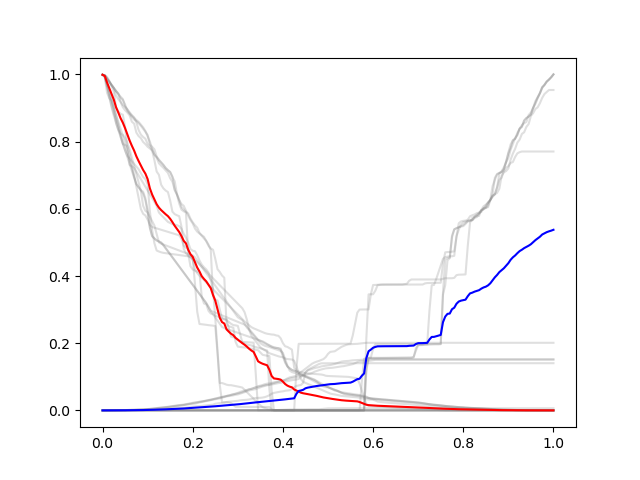

In [3]:
cycle_table = sandbox_directory + "\krel_table_cycle2_1.csv"
cycle_df = pd.read_csv(cycle_table)

x_column = "Sw"
kro_columns = []
krw_columns = []
for column in cycle_df:
    if column.split("_")[-1].isnumeric():
        if column.split("_")[0] == "Kro":
            kro_columns.append(column)
        elif column.split("_")[0] == "Krw":
            krw_columns.append(column)

try:
    plt.close(fig_cycle)
except NameError:
    pass
fig_cycle = plt.figure()

ax_cycle = fig_cycle.add_subplot(111)
for kro_column in kro_columns:
    ax_cycle.plot(cycle_df[x_column], cycle_df[kro_column], c="gray", alpha=0.25)
for krw_column in krw_columns:
    ax_cycle.plot(cycle_df[x_column], cycle_df[krw_column], c="gray", alpha=0.25)
ax_cycle.plot(cycle_df[x_column], cycle_df["Kro_middle"], c="red", alpha=1)
ax_cycle.plot(cycle_df[x_column], cycle_df["Krw_middle"], c="blue", alpha=1)

In [4]:
with open(krel_result_py_path) as f:
    krel_result_code = f.read()
exec(krel_result_code)  # import KrelResult._krel_curve_analysis

df = pd.read_csv(simulation_table)
if experimental_table is not None:
    pnflow_df = pd.read_csv(experimental_table)
    exp_krel = KrelResult._krel_curve_analysis(pnflow_df)

In [5]:
x_column = "Sw"
kro_columns = []
krw_columns = []
for column in cycle_df:
    if column.split("_")[-1].isnumeric():
        if column.split("_")[0] == "Kro":
            kro_columns.append(column)
        elif column.split("_")[0] == "Krw":
            krw_columns.append(column)

In [6]:
angle_columns = []
for column in df:
    if ("_min" in column) or ("_max" in column):
        angle_columns.append(column)
for column in angle_columns:
    df = df.drop(column, axis=1)
df = df.drop("result-no", axis=1)
df = df.drop("result-nw", axis=1)

parameters = []
for column in df:
    if "result-pc" in column:
        signal = np.sign(df[column])
        signal[signal == 0] = 1
        absolute = np.abs(df[column])
        absolute[absolute < 1] = 1
        df[column] = (
            (signal * np.log10(absolute) + np.log10(-df["input-enforced_pc_2"]))
            / (np.log10(df["input-enforced_pc_1"]) + np.log10(-df["input-enforced_pc_2"]))
        ) * 2 - 1
    if "input" not in column:
        continue
    if df[column].nunique() > 1:
        parameters.append(column)

results = []
for column in df:
    if "result" in column:
        results.append(column)

In [7]:
for p in parameters:
    print(p, " ", df[p].unique())

input-oil_viscosity   [1100 3850 6600]
input-interfacial_tension   [ 2 40]
input-init_contact_angle   [ 40  80 120]
input-init_contact_angle_range   [ 1 30]
input-second_contact_fraction   [0.  0.5]
input-equil_contact_angle   [ 40  60  80 100 120]
input-equil_contact_angle_range   [ 1 30]
input-frac_contact_angle   [ 60 100]
input-frac_contact_angle_fraction   [0.  0.5]


In [8]:
if experimental_table is None:
    for column in df:
        if "result" in column:
            result_name = column.split("-")[1]
            mean = df[column].mean()
            df[f"error-{result_name}"] = df[column] - mean
else:
    for column in df:
        if "result" in column:
            result_name = column.split("-")[1]
            mean = exp_krel[result_name]
            df[f"error-{result_name}"] = df[column] - mean

error_columns = df.filter(like="error")
for column in error_columns:
    error_columns.loc[:, column] = error_columns[column] ** 2
df["error-sum"] = error_columns.sum(axis=1)
errors = []
for column in df:
    if "error" in column:
        errors.append(column)

Dropdown(description='X-axis:', options=('error-swi', 'error-kro_swi', 'error-pc_swi', 'error-sw_cross', 'erro…

Dropdown(description='Y-axis:', options=('error-swi', 'error-kro_swi', 'error-pc_swi', 'error-sw_cross', 'erro…

Dropdown(description='Z-axis:', options=('input-oil_viscosity', 'input-interfacial_tension', 'input-init_conta…

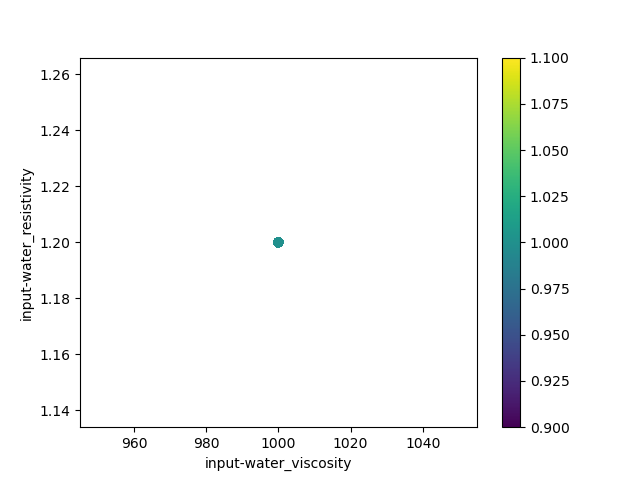

In [9]:
# Plot 1
try:
    plt.close(plot_1_fig)
except NameError:
    pass
plot_1_fig = plt.figure()


def scatter_plot_1(x_col, y_col, z_col):
    plot_1_fig.clf()
    plot_1_ax = plot_1_fig.add_subplot(111)
    scatter_1 = plot_1_ax.scatter(df[x_col], df[y_col], c=df[z_col])
    plot_1_ax.set_xlabel(x_col)
    plot_1_ax.set_ylabel(y_col)
    plot_1_fig.colorbar(scatter_1)


# Define the interactive widgets
x_dropdown_1 = widgets.Dropdown(options=[c for c in df.columns if "error" in c], description="X-axis:")

y_dropdown_1 = widgets.Dropdown(options=[c for c in df.columns if "error" in c], description="Y-axis:")
z_dropdown_1 = widgets.Dropdown(options=parameters, description="Z-axis:")

# Define the interactive function
def update_plot_1(change):
    scatter_plot_1(x_dropdown_1.value, y_dropdown_1.value, z_dropdown_1.value)


# Link the dropdowns to the update function
x_dropdown_1.observe(update_plot_1, names="value")
y_dropdown_1.observe(update_plot_1, names="value")
z_dropdown_1.observe(update_plot_1, names="value")

# Display the dropdowns and initial plot
display(x_dropdown_1)
display(y_dropdown_1)
display(z_dropdown_1)
scatter_plot_1(df.columns[0], df.columns[1], df.columns[2])

Dropdown(description='X-axis:', options=('input-oil_viscosity', 'input-interfacial_tension', 'input-init_conta…

Dropdown(description='Y-axis:', options=('input-oil_viscosity', 'input-interfacial_tension', 'input-init_conta…

Dropdown(description='Z-axis:', options=('error-swi', 'error-kro_swi', 'error-pc_swi', 'error-sw_cross', 'erro…

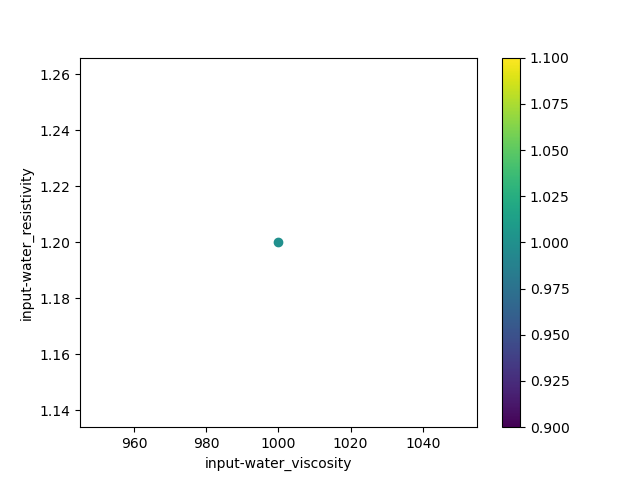

In [10]:
# Plot 2
try:
    plt.close(plot_2_fig)
except NameError:
    pass
plot_2_fig = plt.figure()


def scatter_plot_2(x_col, y_col, z_col):
    plot_2_fig.clf()
    plot_2_ax = plot_2_fig.add_subplot(111)
    grouped_df = df[[x_col, y_col, z_col]]
    grouped_df = grouped_df.groupby([x_col, y_col], as_index=False).mean()
    scatter_2 = plot_2_ax.scatter(grouped_df[x_col], grouped_df[y_col], c=grouped_df[z_col])
    plot_2_ax.set_xlabel(x_col)
    plot_2_ax.set_ylabel(y_col)
    plot_2_fig.colorbar(scatter_2)


# Define the interactive widgets
x_dropdown_2 = widgets.Dropdown(options=parameters, description="X-axis:")
y_dropdown_2 = widgets.Dropdown(options=parameters, description="Y-axis:")
z_dropdown_2 = widgets.Dropdown(options=[c for c in df.columns if "error" in c], description="Z-axis:")

# Define the interactive function
def update_plot_2(change):
    scatter_plot_2(x_dropdown_2.value, y_dropdown_2.value, z_dropdown_2.value)


# Link the dropdowns to the update function
x_dropdown_2.observe(update_plot_2, names="value")
y_dropdown_2.observe(update_plot_2, names="value")
z_dropdown_2.observe(update_plot_2, names="value")

# Display the dropdowns and initial plot
display(x_dropdown_2)
display(y_dropdown_2)
display(z_dropdown_2)
scatter_plot_2(df.columns[0], df.columns[1], df.columns[2])

In [11]:
# Pearson correlation of inputs with sum of errors
for p in parameters:
    # levels = df[p].unique()
    corr = stats.pearsonr(df[p], df["error-sum"])
    print(p, f"\tCorrelation: {corr[0]}\tP-value: {corr[1]}")

input-oil_viscosity 	Correlation: 0.0014917384343410792	P-value: 0.936221049833177
input-interfacial_tension 	Correlation: -0.005859784370925846	P-value: 0.7532664577027827
input-init_contact_angle 	Correlation: 0.4520497467499587	P-value: 4.5336330034470794e-145
input-init_contact_angle_range 	Correlation: -0.06494105825214273	P-value: 0.00048797596777494783
input-second_contact_fraction 	Correlation: -0.3627139821832307	P-value: 2.8666245224341104e-90
input-equil_contact_angle 	Correlation: 0.2032885619601921	P-value: 3.0559996942878777e-28
input-equil_contact_angle_range 	Correlation: -0.014964070878544865	P-value: 0.42211772218650834
input-frac_contact_angle 	Correlation: -0.0030098750693900557	P-value: 0.8717334045087023
input-frac_contact_angle_fraction 	Correlation: -0.0017897684053404471	P-value: 0.9235146697559958


In [12]:
# Linear regression of error as a function of a single parameter
for p in parameters:
    # levels = df[p].unique()
    linreg = stats.linregress(df[p], df["error-sum"])
    print(p, f"\tSlope: {linreg[0]}\tIntercept: {linreg[1]}\tP-value: {linreg[3]}")

input-oil_viscosity 	Slope: 13.846330598958332	Intercept: 384199006286315.06	P-value: 0.9362210498331788
input-interfacial_tension 	Slope: -6427.722452942252	Intercept: 384199006474605.6	P-value: 0.7532664577027794
input-init_contact_angle 	Slope: 288470.19634277344	Intercept: 384198983262007.75	P-value: 4.533633003447827e-145
input-init_contact_angle_range 	Slope: -93342.71759458813	Intercept: 384199007786435.56	P-value: 0.00048797596777494826
input-second_contact_fraction 	Slope: -30238021.42482639	Intercept: 384199013899128.8	P-value: 2.866624522434249e-90
input-equil_contact_angle 	Slope: 149794.90155381945	Intercept: 384198994356031.3	P-value: 3.055999694287333e-28
input-equil_contact_angle_range 	Slope: -21508.535272988505	Intercept: 384199006673005.75	P-value: 0.42211772218650456
input-frac_contact_angle 	Slope: -3136.5163498263887	Intercept: 384199006590544.75	P-value: 0.8717334045087057
input-frac_contact_angle_fraction 	Slope: -149205.87031250002	Intercept: 384199006376924.9	

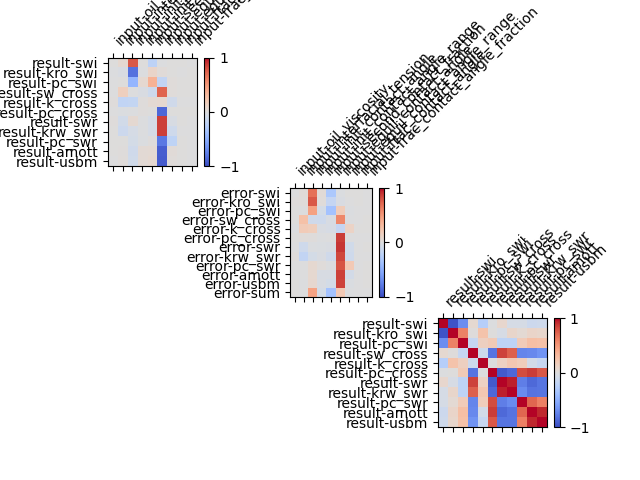

In [13]:
try:
    plt.close(fig_corr)
except NameError:
    pass
fig_corr = plt.figure()

sqerror_df = df.copy()
for column in sqerror_df:
    if "error" in column and "sum" not in column:
        sqerror_df[column] = sqerror_df[column] ** 2

corr = sqerror_df[parameters + results + errors].corr()
ax1_corr = fig_corr.add_subplot(331)
ax2_corr = fig_corr.add_subplot(335)
ax3_corr = fig_corr.add_subplot(339)
cax = []
for ax, columns, rows in zip(
    (ax1_corr, ax2_corr, ax3_corr),
    (parameters, parameters, results),
    (results, errors, results),
):
    sub_corr = corr[columns].loc[rows]
    cax.append(ax.matshow(sub_corr, cmap="coolwarm", vmin=-1, vmax=1))
    fig_corr.colorbar(cax[-1])
    column_ticks = np.arange(0, len(sub_corr.columns), 1)
    row_ticks = np.arange(0, len(sub_corr.index), 1)
    ax.set_xticks(column_ticks)
    ax.set_yticks(row_ticks)
    ax.set_xticklabels(sub_corr.columns)
    ax.set_yticklabels(sub_corr.index)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="left")
    # plt.xticks(rotation=45)

In [14]:
renamed_df = df.rename(lambda x: x.replace("-", "_"), axis=1)
params_list = []
for p in parameters:
    params_list.append(p.replace("-", "_"))
params_string = " + ".join(params_list)

mod = ols(formula=f"error_sum ~ ({params_string}) ** 2", data=renamed_df).fit()
anova = sm.stats.anova_lm(mod, typ=3)

anova_parameters = {}
for column in anova.index:
    if ":" not in column and column != "Intercept" and column != "Residual":
        anova_parameters[column] = len(anova_parameters)

anova_df = pd.DataFrame(columns=anova_parameters, index=anova_parameters)

for i in anova.index:
    if ":" not in i and i != "Intercept" and i != "Residual":
        anova_df.loc[i][i] = anova.loc[i]["PR(>F)"]
    elif i != "Intercept" and i != "Residual":
        j, k = i.split(":")
        anova_df.loc[j][k] = anova.loc[i]["PR(>F)"]
        anova_df.loc[k][j] = anova.loc[i]["PR(>F)"]

for i in anova_df:
    anova_df[i] = anova_df[i].astype(float)

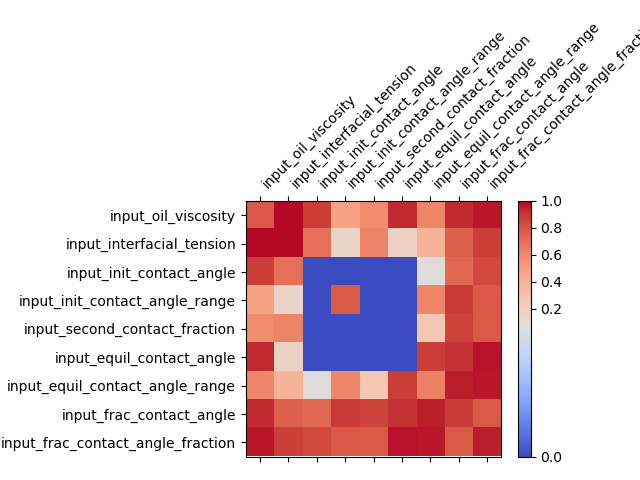

In [15]:
try:
    plt.close(fig_anova)
except NameError:
    pass
fig_anova = plt.figure()
anova_ax = fig_anova.add_subplot(111)

normalizer = colors.TwoSlopeNorm(0.05, vmin=0, vmax=1)
mat_ax = anova_ax.matshow(anova_df, cmap="coolwarm", norm=normalizer)
fig_anova.colorbar(mat_ax)
column_ticks = np.arange(0, len(anova_df.columns), 1)
row_ticks = np.arange(0, len(anova_df.index), 1)
anova_ax.set_xticks(column_ticks)
anova_ax.set_yticks(row_ticks)
anova_ax.set_xticklabels(anova_df.columns)
anova_ax.set_yticklabels(anova_df.index)
anova_ax.set_xticks(anova_ax.get_xticks(), anova_ax.get_xticklabels(), rotation=45, ha="left")
fig_anova.tight_layout()

In [16]:
anova_p = anova["PR(>F)"]

for i in anova_p.index:
    if i.count(":") < 1:
        anova_p = anova_p.drop(i)

anova_p.sort_values(inplace=True)

alpha = 0.05
gcolor = anova_p.copy()
for i in gcolor.index:
    if gcolor[i] == alpha:
        gcolor[i] = 0.5
    elif gcolor[i] < 0.8 * alpha:
        gcolor[i] = 1 - (0.25 - ((gcolor[i] - 0.8 * alpha) / (0 - 0.8 * alpha)) * 0.25)
    elif gcolor[i] < alpha and gcolor[i] >= 0.8 * alpha:
        gcolor[i] = 1 - (0.40 - ((gcolor[i] - alpha) / (0.8 * alpha - alpha)) * 0.15)
    elif gcolor[i] > alpha and gcolor[i] <= 2 * alpha:
        gcolor[i] = 1 - (0.5 + ((gcolor[i] - alpha) / (2 * alpha - alpha)) * 0.40)
    elif gcolor[i] > 2 * alpha:
        gcolor[i] = 1 - (0.90 + ((gcolor[i] - 2 * alpha) / (1 - 2 * alpha)) * 0.10)
    if gcolor[i] == alpha:
        gcolor[i] = 0.5
stiler = pd.DataFrame(anova_p).style.background_gradient(cmap="RdYlGn", gmap=gcolor, vmin=0, vmax=1)
stiler

,PR(>F)
input_init_contact_angle:input_second_contact_fraction,0.000000
input_init_contact_angle:input_equil_contact_angle,0.000000
input_second_contact_fraction:input_equil_contact_angle,0.000000
input_init_contact_angle:input_init_contact_angle_range,0.000000
input_init_contact_angle_range:input_second_contact_fraction,0.000000
input_init_contact_angle_range:input_equil_contact_angle,0.000387
input_init_contact_angle:input_equil_contact_angle_range,0.060942
input_interfacial_tension:input_init_contact_angle_range,0.161081
input_interfacial_tension:input_equil_contact_angle,0.179364
input_second_contact_fraction:input_equil_contact_angle_range,0.253237


In [17]:
mod3 = ols(formula=f"error_sum ~ ({params_string}) ** 3", data=renamed_df).fit()
anova3 = sm.stats.anova_lm(mod3, typ=3)

anova3 = anova3["PR(>F)"]

for i in anova3.index:
    if i.count(":") < 2:
        anova3 = anova3.drop(i)

anova3.sort_values(inplace=True)

alpha = 0.05
gcolor = anova3.copy()
for i in gcolor.index:
    if gcolor[i] == alpha:
        gcolor[i] = 0.5
    elif gcolor[i] < 0.8 * alpha:
        gcolor[i] = 1 - (0.25 - ((gcolor[i] - 0.8 * alpha) / (0 - 0.8 * alpha)) * 0.25)
    elif gcolor[i] < alpha and gcolor[i] >= 0.8 * alpha:
        gcolor[i] = 1 - (0.40 - ((gcolor[i] - alpha) / (0.8 * alpha - alpha)) * 0.15)
    elif gcolor[i] > alpha and gcolor[i] <= 2 * alpha:
        gcolor[i] = 1 - (0.5 + ((gcolor[i] - alpha) / (2 * alpha - alpha)) * 0.40)
    elif gcolor[i] > 2 * alpha:
        gcolor[i] = 1 - (0.90 + ((gcolor[i] - 2 * alpha) / (1 - 2 * alpha)) * 0.10)
    if gcolor[i] == alpha:
        gcolor[i] = 0.5
stiler = pd.DataFrame(anova3).style.background_gradient(cmap="RdYlGn", gmap=gcolor, vmin=0, vmax=1)
stiler

,PR(>F)
input_init_contact_angle:input_second_contact_fraction:input_equil_contact_angle,0.000000
input_init_contact_angle:input_init_contact_angle_range:input_second_contact_fraction,0.000000
input_init_contact_angle:input_init_contact_angle_range:input_equil_contact_angle,0.000002
input_init_contact_angle_range:input_second_contact_fraction:input_equil_contact_angle,0.000414
input_interfacial_tension:input_init_contact_angle:input_init_contact_angle_range,0.062398
input_interfacial_tension:input_init_contact_angle:input_equil_contact_angle,0.091164
input_interfacial_tension:input_second_contact_fraction:input_equil_contact_angle,0.095571
input_init_contact_angle:input_second_contact_fraction:input_equil_contact_angle_range,0.127452
input_interfacial_tension:input_init_contact_angle_range:input_second_contact_fraction,0.225651
input_interfacial_tension:input_init_contact_angle:input_equil_contact_angle_range,0.232522
